<a href="https://colab.research.google.com/github/baeksumin/k-project/blob/main/data_preprocessing/TimeSeries_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy import interpolate

In [ ]:
# 조건에 해당하는 날짜 추출.
def get_point(result):
  x = list(result['x1'])+ list(result['x2'])
  x = list(set(x))
  x.sort()
  return x

# 전체 df에서 해당 날짜만 가져오기
def get_date(date_list):
  global scode1
  
  if(len(date_list)==0):#아예 조건에 해당하는 점이 없을 경우
    return pd.DataFrame() 
    
  check_df =  scode1[scode1.x == date_list[0]]

  for i in date_list :
    df = scode1[scode1.x == i]
    check_df = check_df.append(df,ignore_index = True)

  check_df = check_df.iloc[1:,:]
  return check_df


# 두 점 사이 관계 df 
def two_point (check_df):

  df = check_df[['x']]
  df= df.iloc[:-1]

  df[['x2','y1','y2','t','p','m']] = np.nan
  df.rename(columns ={'x':'x1'}, inplace = True)

  for i in range(len(df)): 
    df.iloc[i,1] = check_df.iloc[i+1,0]
    df.iloc[i,2] = check_df.iloc[i,1]
    df.iloc[i,3] = check_df.iloc[i+1,1]

  for i in range(df.shape[0]):

    t = df.iloc[i,1] - df.iloc[i,0]
    df.iloc[i,4] = t.days

    y1 = df.iloc[i,2]
    y2 = df.iloc[i,3]
    result = (abs(y2 - y1 )) / ((y1+y2)/2 )
    df.iloc[i,5] = result

    m = df.iloc[i,3]- df.iloc[i,2]  
    if (m>0):
      df.iloc[i,6] = 1
    elif (m<0):
      df.iloc[i,6] = -1
    else :
      df.iloc[i,6] = 0

  return df


# 조건 필터링 
def p_t(df):
  t = df['t'] <5
  p = df['p']<0.05

  result = df[~t&~p]
  return result


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/[Shared]K-Project/data/'

# 저장된 개별종목 데이터 가져오기
with open(data_path + 'initial_data1.json',"r") as json_file:
    json_data = json.load(json_file)

#저장된 fullcode 데이터 가져오기
with open(data_path + 'full_code.pkl',"rb") as f: 
    fullcode = pickle.load(f)
    
# 상장폐지 상태 제외시키기
fullcode_filter = fullcode[fullcode['status'] != '상장폐지']

# fullcode열을 list로 변경
fullcode_list = list(fullcode_filter['full_code'])
print(fullcode_list[:10])

['KR7060310000', 'KR7095570008', 'KR7006840003', 'KR7054620000', 'KR7265520007', 'KR7211270004', 'KR7027410000', 'KR7282330000', 'KR7138930003', 'KR7001460005']


In [ ]:

global scode1

num = 0
for j in (fullcode_list[2596:len(fullcode_list)]):

  df = pd.read_json(json_data[j], orient ='index')
  scode = df.transpose()
  num = fullcode_list.index(j)
  print(num,"번째,  ", j)

   
  #시간 순 재정렬.
  scode = scode.sort_values(by=['TRD_DD'])
  scode.reset_index(drop=True,inplace=True)
  scode['TRD_DD']=pd.to_datetime(scode['TRD_DD']) #datetime변환

  #시가총액 str->float 데이터타입변환
  scode['MKTCAP'] = scode['MKTCAP'].str.replace(',','').astype('float')

  #날짜, 시가총액 열만 추출
  scode1 = scode[['TRD_DD','MKTCAP']]
  scode1 = scode1.rename(columns = {'TRD_DD':'x','MKTCAP':'y'})
  scode1.reset_index(drop=True,inplace=True)


  #기울기 변하는 지점 찾아주기
  ischange = list()

  for i in range(1,len(scode1)-2):
    m1 = scode1.iloc[i,1] - scode1.iloc[i-1,1]
    m2 = scode1.iloc[i+1,1] - scode1.iloc[i,1]

    if(m1*m2<=0):
        ischange.append(scode1.iloc[i,0])

  # 전체 df에서 기울기 변하는 지점들만 추출한 후 , (t=5, p=0.05) 에 해당하는 날짜  추출.

  check_df = get_date(ischange) #전체 df에서 기울기 변하는 날짜만 추출하기.
  if(len(check_df)==0):
    print("\n기울기 변하는 날짜가 존재 하지 않음. 조건 성립 X")
    print("\n-----------------------------------------------------------------------------------------\n")
    continue
  df = two_point(check_df)
  result = p_t(df)   # (t=5, p=0.05) 에 해당하는 날짜  추출.



  # 조건에 해당하는 날짜들끼리 다시 (t=5, p=0.05) 에 해당하는 날짜  추출. 
  red_x = get_point(result)
  red = get_date(red_x)

  if(len(red)==0): #아예 trend 점 안만들어지는 종목 에러 방지.
    print("\n조건에 해당하는 점이 아예 없음.")
    print("\n-----------------------------------------------------------------------------------------\n")
    continue
  df1=two_point(red)
  result2=p_t(df1)


  #점들이 모두 이어지고, 기울기가 계속 변하는 모습 나올때까지 반복 작업.
  while True:
      
    count = 0
      
    red_x1 = get_point(result2) #조건에 만족하는 날짜 추출

    for i in range(result2.shape[0]-1):
      a = result2.iloc[i,1] == result2.iloc[i+1,0]
      b = result2.iloc[i,6]* result2.iloc[i+1,6]== -1

      if(a&b ) :
        count+=1
        
    if (count ==  result2.shape[0]-1 ):
        print('\n'+j+" 조건 성립 완료 \n")
        break
          
    for i in range(result2.shape[0]-1):

       #i번째 기울기 음수일때
      if (result2.iloc[i,6]== -1):  
        #i+1번째 기울기 양수일 때
        if (result2.iloc[i+1,6] == 1): 
          #점이 이어져 있지 않으면
          if (result2.iloc[i,1] != result2.iloc[i+1,0]):
            if(result2.iloc[i,3]> result2.iloc[i+1,2]):
               red_x1.remove(result2.iloc[i,1])
            else :
              red_x1.remove(result2.iloc[i+1,0]) 
                
        #i+1번째 기울기 음수일 때
        elif (result2.iloc [i+1,6]== -1):       
           red_x1.remove(result2.iloc[i,1])


      #i번째 기울기 양수일때
      else :   
        #i+1번째 기울기 양수일 때
        if (result2.iloc[i+1,6] == 1): 
          #점이 이어져 있지 않으면
          if (result2.iloc[i,1] != result2.iloc[i+1,0]):
            red_x1.remove(result2.iloc[i,1])
            red_x1.remove(result2.iloc[i+1,0]) 
          #점이 이어져 있으면
          else :
            red_x1.remove(result2.iloc[i,1])
        #i+1번째 기울기 음수일 때
        else :
          #점이 이어져 있지 않으면
          if (result2.iloc[i,1] != result2.iloc[i+1,0]):
            if (result2.iloc[i,3]>=result2.iloc[i+1,2]):
               red_x1.remove(result2.iloc[i+1,0])
            else:
              red_x1.remove(result2.iloc[i,1])
        
    final = get_date(red_x1)
    df1=two_point(final)
    result2=p_t(df1)


  # trend -1~1 사이 값으로 변환.

  final = get_date(red_x1) #최종 기울기 변하는 점 추출.

  for j in range(final.shape[0]-1): #기울기 변하는 곳 1, -1로 값 채워주기
    if(result2.iloc[j,6]== 1):
      final.iloc[j,1] = -1
    else :
      final.iloc[j,1] = 1

  # 마지막 끝 점 (-1,1)해당하는 값으로 채워주기
  n = final.shape[0]-2
  if(final.iloc[n,1]== -1):
     final.iloc[final.shape[0]-1,1] = 1
  else:
     final.iloc[final.shape[0]-1,1] = -1

   # -1~ 1 사이 점 채워주기.(linear interpolation)
  scode_trend = scode1[['x']]
  scode_trend['TREND'] = np.nan

  for i in range(len(final)):
    scode_trend.loc[scode_trend['x']== final.iloc[i,0],'TREND'] = final.iloc[i,1]

  scode_trend =  scode_trend.set_index('x')
  scode_trend = scode_trend[final.iloc[0,0]:final.iloc[len(final)-1,0]].interpolate(method = "time")


  # 마지막으로 원래 데이터에 TREND 열 만들어주어서 합치기.
  scode_trend.reset_index(inplace=True)
  scode_trend = scode_trend.rename(columns = {'x':'TRD_DD'})
  scode = pd.merge(scode, scode_trend, on='TRD_DD', how='left')

  scode = scode.sort_values(by=['TRD_DD'], ascending=False)
  scode.reset_index(drop=True,inplace=True)

  num +=1


  print("\n-----------------------------------------------------------------------------------------\n")

2596 번째,   KR7357880004

기울기 변하는 날짜가 존재 하지 않음. 조건 성립 X

-----------------------------------------------------------------------------------------

2597 번째,   KR7376300000

기울기 변하는 날짜가 존재 하지 않음. 조건 성립 X

-----------------------------------------------------------------------------------------

2598 번째,   KR7311320006

기울기 변하는 날짜가 존재 하지 않음. 조건 성립 X

-----------------------------------------------------------------------------------------

2599 번째,   KR7372800003

기울기 변하는 날짜가 존재 하지 않음. 조건 성립 X

-----------------------------------------------------------------------------------------



In [ ]:
scode #마지막 종목 확인.

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD
0,2021-11-08,389030,지니너스,"13,400","18,000","19,450","13,400",1.456488e+11,"4,802,621",-,-,-,-,0,0.00
1,2021-11-09,389030,지니너스,"12,800","13,350","13,700","12,250",1.391272e+11,"1,156,403",-,-,-,-,0,0.00
2,2021-11-10,389030,지니너스,"12,150","12,700","12,750","12,100",1.320622e+11,"441,404",-,-,-,-,0,0.00
3,2021-11-11,389030,지니너스,"12,350","12,100","12,900","12,100",1.342360e+11,"450,149",-,-,-,-,0,0.00
4,2021-11-12,389030,지니너스,"12,650","12,350","13,500","12,250",1.374968e+11,"554,986",-,-,-,-,0,0.00


In [ ]:
scode[~scode.TREND.isnull()] #trend로 변환된 부분 확인.

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD,TREND
26,2021-10-06,084670,동양고속,"20,850","21,850","21,850","20,200",6.037261e+10,"10,549",-,-,"36,836",0.57,500,2.40,-1.000000
27,2021-10-05,084670,동양고속,"21,450","21,750","21,950","21,350",6.210996e+10,"6,318",-,-,"36,836",0.58,500,2.33,-0.984000
28,2021-10-01,084670,동양고속,"22,000","22,200","22,200","21,850",6.370252e+10,"6,410",-,-,"36,836",0.60,500,2.27,-0.920000
29,2021-09-30,084670,동양고속,"22,250","21,900","22,250","21,850",6.442641e+10,"1,353",-,-,"36,836",0.60,500,2.25,-0.904000
30,2021-09-29,084670,동양고속,"22,050","22,000","22,050","21,650",6.384730e+10,"5,552",-,-,"36,836",0.60,500,2.27,-0.888000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4024,2005-08-04,084670,동양고속,"13,450","13,550","14,100","13,000",1.367498e+10,"31,844",-,-,-,-,0,0.00,0.636364
4025,2005-08-03,084670,동양고속,"13,900","14,050","14,200","13,900",1.413251e+10,"34,539",-,-,-,-,0,0.00,0.696970
4026,2005-08-02,084670,동양고속,"14,200","14,450","14,800","14,100",1.443752e+10,"17,176",-,-,-,-,0,0.00,0.757576
4027,2005-08-01,084670,동양고속,"14,550","14,650","14,950","14,500",1.479338e+10,"28,456",-,-,-,-,0,0.00,0.818182


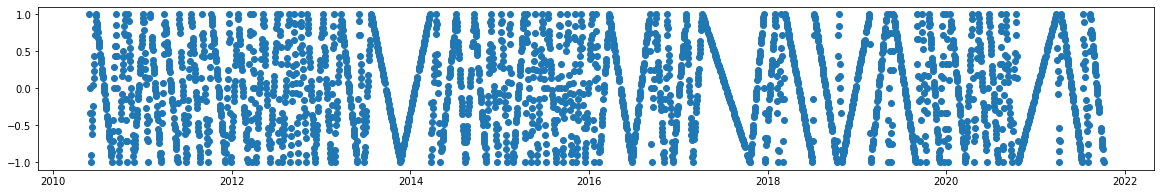

In [ ]:
#마지막 번째 그림으로 확인

scode = scode.sort_values(by=['TRD_DD'])
scode.reset_index(drop=True,inplace=True)



plt.figure(figsize=(20,3))
plt.scatter(scode.TRD_DD,scode.TREND)

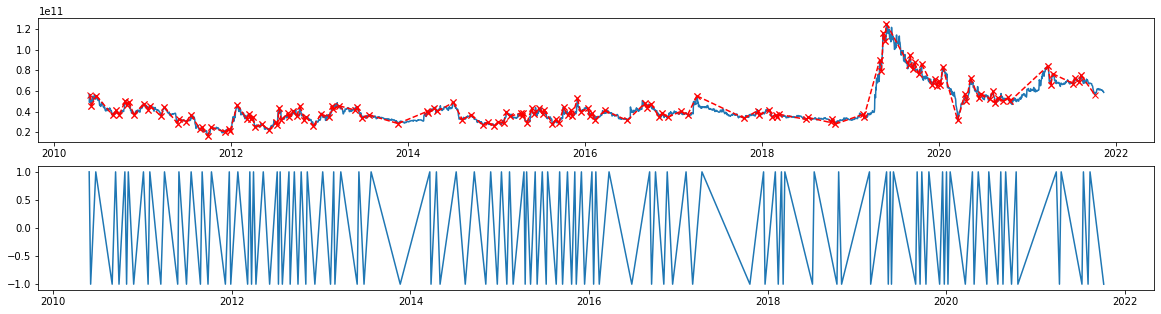

In [ ]:
#마지막 번째 그림으로 확인

scode = scode.sort_values(by=['TRD_DD'])
scode.reset_index(drop=True,inplace=True)

fig = plt.figure(figsize = (20, 5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


ax1.plot(scode['TRD_DD'],scode['MKTCAP'])
#ax1.set_xlim([datetime.date(2017, 7, 1), datetime.date(2021, 10, 20)])
#ax1.set_ylim(0,3e11)
#ax1.plot(x,y, color = "orange", linestyle = "--")

for i in range(result2.shape[0]):
  x1 = list(result2.iloc[i,:2])
  y1 = list(result2.iloc[i,2:4])
  ax1.plot(x1,y1, "rx--")


ax2.plot(scode['TRD_DD'],scode['TREND'])
#ax2.set_xlim([datetime.date(2017, 7, 1), datetime.date(2021, 10, 20)])

<br><br><br><br><br><hr>
<h1><b>코드 확인용</b> </h1>

In [ ]:
# (KR7005930003) 데이터 가져오기
df = pd.read_json(json_data['KR7376300000'], orient ='index') 
samsung = df.transpose()
samsung

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD
0,2021/11/12,376300,디어유,"64,200","66,900","71,000","62,800","1,293,708,966,000","1,533,104",-,-,-,-,0,0.00
1,2021/11/11,376300,디어유,"65,700","62,000","68,400","58,600","1,323,935,811,000","2,413,647",-,-,-,-,0,0.00
2,2021/11/10,376300,디어유,"66,500","52,000","67,600","52,000","1,340,056,795,000","6,030,012",-,-,-,-,0,0.00


In [ ]:
#시간 순 재정렬.
samsung = samsung.sort_values(by=['TRD_DD'])
samsung.reset_index(drop=True,inplace=True)
samsung['TRD_DD']=pd.to_datetime(samsung['TRD_DD']) #datetime변환

#시가총액 str->float 데이터타입변환
samsung['MKTCAP'] = samsung['MKTCAP'].str.replace(',','').astype('float')

#날짜, 시가총액 열만 추출
samsung01 = samsung[['TRD_DD','MKTCAP']]
#samsung01= samsung01[(samsung01['TRD_DD']>='2017-01-01') & (samsung01['TRD_DD']<='2021-10-20')]
samsung01 = samsung01.rename(columns = {'TRD_DD':'x','MKTCAP':'y'})
samsung01.reset_index(drop=True,inplace=True)
samsung01

,x,y
0,2021-11-10,1.340057e+12
1,2021-11-11,1.323936e+12
2,2021-11-12,1.293709e+12


In [ ]:
# 조건에 해당하는 날짜 추출.
def get_point(result):
  x = list(result['x1'])+ list(result['x2'])
  x = list(set(x))
  x.sort()
  return x

# 전체 df에서 해당 날짜만 가져오기
def get_date(date_list):
  if(len(date_list)==0):#아예 조건에 해당하는 점이 없을 경우
    return pd.DataFrame() 
  check_df =  scode1[scode1.x == date_list[0]]

  for i in date_list :
    df = scode1[scode1.x == i]
    check_df = check_df.append(df,ignore_index = True)

  check_df = check_df.iloc[1:,:]
  return check_df


# 두 점 사이 관계 df 
def two_point (check_df):

  df = check_df[['x']]
  df= df.iloc[:-1]

  df[['x2','y1','y2','t','p','m']] = np.nan
  df.rename(columns ={'x':'x1'}, inplace = True)

  for i in range(len(df)): 
    df.iloc[i,1] = check_df.iloc[i+1,0]
    df.iloc[i,2] = check_df.iloc[i,1]
    df.iloc[i,3] = check_df.iloc[i+1,1]

  for i in range(df.shape[0]):

    t = df.iloc[i,1] - df.iloc[i,0]
    df.iloc[i,4] = t.days

    y1 = df.iloc[i,2]
    y2 = df.iloc[i,3]
    result = (abs(y2 - y1 )) / ((y1+y2)/2 )
    df.iloc[i,5] = result

    m = df.iloc[i,3]- df.iloc[i,2]  
    if (m>0):
      df.iloc[i,6] = 1
    elif (m<0):
      df.iloc[i,6] = -1
    else :
      df.iloc[i,6] = 0

  return df


# 조건 필터링 
def p_t(df):
  t = df['t'] <5
  p = df['p']<0.05

  result = df[~t&~p]
  return result


In [ ]:
#기울기 변하는 지점 찾아주기

ischange = list()

for i in range(1,len(samsung01)-2):
  m1 = samsung01.iloc[i,1] - samsung01.iloc[i-1,1]
  m2 = samsung01.iloc[i+1,1] - samsung01.iloc[i,1]

  if(m1*m2<=0):
    ischange.append(samsung01.iloc[i,0])

# 전체 df에서 기울기 변하는 지점들만 추출한 후 , (t=5, p=0.05) 에 해당하는 날짜  추출.

check_df = get_date(ischange) #전체 df에서 기울기 변하는 날짜만 추출하기.
print(ischange)
df = two_point(check_df)
result = p_t(df)   # (t=5, p=0.05) 에 해당하는 날짜  추출.
result

[Timestamp('2021-11-10 00:00:00')]


,x1,x2,y1,y2,t,p,m


In [ ]:
# 조건에 해당하는 날짜들끼리 다시 (t=5, p=0.05) 에 해당하는 날짜  추출. 
red_x = get_point(result)
red = get_date(red_x)
df1=two_point(red)
result2=p_t(df1)
result2

,x1,x2,y1,y2,t,p,m
1,2021-05-25,2021-05-31 00:00:00,1.113870e+10,1.220572e+10,6.0,0.091416,1.0
3,2021-07-15,2021-07-20 00:00:00,1.184138e+10,1.249200e+10,5.0,0.053476,1.0


In [ ]:
#점들이 모두 이어지고, 기울기가 계속 변하는 모습 나올때까지 반복 작업.

while True:
  
  count = 0
  
  red_x1 = get_point(result2) #조건에 만족하는 날짜 추출

  for i in range(result2.shape[0]-1):
    a = result2.iloc[i,1] == result2.iloc[i+1,0]
    b = result2.iloc[i,6]* result2.iloc[i+1,6]== -1

    if(a&b ) :
      count+=1
    
  if (count ==  result2.shape[0]-1 ):
      print("조건 성립 완료")
      break
      
  for i in range(result2.shape[0]-1):

    #i번째 기울기 음수일때
    if (result2.iloc[i,6]== -1):  
      #i+1번째 기울기 양수일 때
      if (result2.iloc[i+1,6] == 1): 
        #점이 이어져 있지 않으면
        if (result2.iloc[i,1] != result2.iloc[i+1,0]):
          if(result2.iloc[i,3]> result2.iloc[i+1,2]):
            red_x1.remove(result2.iloc[i,1])
          else :
            red_x1.remove(result2.iloc[i+1,0]) 
            
      #i+1번째 기울기 음수일 때
      elif (result2.iloc [i+1,6]== -1):       
        red_x1.remove(result2.iloc[i,1])


    #i번째 기울기 양수일때
    else :   
      #i+1번째 기울기 양수일 때
      if (result2.iloc[i+1,6] == 1): 
        #점이 이어져 있지 않으면
        if (result2.iloc[i,1] != result2.iloc[i+1,0]):
          red_x1.remove(result2.iloc[i,1])
          red_x1.remove(result2.iloc[i+1,0]) 
        #점이 이어져 있으면
        else :
          red_x1.remove(result2.iloc[i,1])
      #i+1번째 기울기 음수일 때
      else :
        #점이 이어져 있지 않으면
        if (result2.iloc[i,1] != result2.iloc[i+1,0]):
          if (result2.iloc[i,3]>=result2.iloc[i+1,2]):
            red_x1.remove(result2.iloc[i+1,0])
          else:
            red_x1.remove(result2.iloc[i,1])
     
  final = get_date(red_x1)
  df1=two_point(final)
  result2=p_t(df1)
  result2


조건 성립 완료


In [ ]:
result2

,x1,x2,y1,y2,t,p,m
1,2021-05-25,2021-07-20 00:00:00,1.113870e+10,1.249200e+10,56.0,0.114537,1.0


In [ ]:
# trend -1~1 사이 값으로 변환.

final = get_date(red_x1) #최종 기울기 변하는 점 추출.

for i in range(final.shape[0]-1): #기울기 변하는 곳 1, -1로 값 채워주기
  if(result2.iloc[i,6]== 1):
    final.iloc[i,1] = -1
  else :
    final.iloc[i,1] = 1

# 마지막 끝 점 (-1,1)해당하는 값으로 채워주기
n = final.shape[0]-2
if(final.iloc[n,1]== -1):
  final.iloc[final.shape[0]-1,1] = 1
else:
  final.iloc[final.shape[0]-1,1] = -1

# -1~ 1 사이 점 채워주기.
samsung_trend = samsung01[['x']]
samsung_trend['TREND'] = np.nan

for i in range(len(final)):
  samsung_trend.loc[samsung_trend['x']== final.iloc[i,0],'TREND'] = final.iloc[i,1]

samsung_trend =  samsung_trend.set_index('x')
samsung_trend = samsung_trend[final.iloc[0,0]:final.iloc[len(final)-1,0]].interpolate(method = "time")

# 마지막으로 원래 데이터에 TREND 열 만들어주어서 합치기.
samsung_trend.reset_index(inplace=True)
samsung_trend = samsung_trend.rename(columns = {'x':'TRD_DD'})
samsung = pd.merge(samsung, samsung_trend, on='TRD_DD', how='left')
samsung

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD,TREND
0,2019-10-11,332290,대신밸런스제7호스팩,"2,025","2,025","2,035","2,015",1.054012e+10,"2,275,942",-,-,-,-,-,-,NaN
1,2019-10-14,332290,대신밸런스제7호스팩,"2,020","2,025","2,025","2,020",1.051410e+10,"302,792",-,-,-,-,-,-,NaN
2,2019-10-15,332290,대신밸런스제7호스팩,"2,025","2,020","2,030","2,020",1.054012e+10,"95,600",-,-,-,-,-,-,NaN
3,2019-10-16,332290,대신밸런스제7호스팩,"2,030","2,025","2,030","2,025",1.056615e+10,"110,468",-,-,-,-,-,-,NaN
4,2019-10-17,332290,대신밸런스제7호스팩,"2,030","2,025","2,030","2,025",1.056615e+10,"81,770",-,-,-,-,-,-,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,2021-11-08,332290,대신밸런스제7호스팩,"2,400",0,0,0,1.249200e+10,0,-,-,-,-,-,-,NaN
514,2021-11-09,332290,대신밸런스제7호스팩,"2,400",0,0,0,1.249200e+10,0,-,-,-,-,-,-,NaN
515,2021-11-10,332290,대신밸런스제7호스팩,"2,400",0,0,0,1.249200e+10,0,-,-,-,-,-,-,NaN
516,2021-11-11,332290,대신밸런스제7호스팩,"2,400",0,0,0,1.249200e+10,0,-,-,-,-,-,-,NaN


In [ ]:
a= scode[~scode.TREND.isnull()]
a

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD,TREND
4,2019-08-16,00104K,CJ4우(전환),"51,100","51,200","51,800","50,000",2.159748e+11,"63,207",-,-,-,-,-,-,-1.000000
5,2019-08-19,00104K,CJ4우(전환),"52,500","51,700","54,100","51,400",2.218919e+11,"82,918",-,-,-,-,-,-,-0.955882
6,2019-08-20,00104K,CJ4우(전환),"53,800","53,200","53,800","52,500",2.273863e+11,"37,312",-,-,-,-,-,-,-0.941176
7,2019-08-21,00104K,CJ4우(전환),"55,000","53,800","56,000","53,200",2.324582e+11,"41,778",-,-,-,-,-,-,-0.926471
8,2019-08-22,00104K,CJ4우(전환),"56,400","55,000","56,700","55,000",2.383753e+11,"27,663",-,-,-,-,-,-,-0.911765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,2021-08-19,00104K,CJ4우(전환),"80,600","83,700","83,700","80,500",3.406569e+11,"12,322",-,-,-,-,"2,000",2.48,-0.980198
502,2021-08-20,00104K,CJ4우(전환),"79,400","80,800","81,500","78,000",3.355851e+11,"14,771",-,-,-,-,"2,000",2.52,-1.000000
503,2021-08-23,00104K,CJ4우(전환),"80,800","79,900","81,500","79,400",3.415022e+11,"5,643",-,-,-,-,"2,000",2.48,0.200000
504,2021-08-24,00104K,CJ4우(전환),"82,500","81,400","82,900","81,400",3.486872e+11,"4,851",-,-,-,-,"2,000",2.42,0.600000


In [ ]:
b = samsung[~samsung.TREND.isnull()]
b

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD,TREND
400,2021-05-25,332290,대신밸런스제7호스팩,"2,140","2,160","2,160","2,135",1.113870e+10,"6,724",-,-,-,-,-,-,-1.000000
401,2021-05-26,332290,대신밸런스제7호스팩,"2,175","2,160","2,215","2,155",1.132088e+10,"58,500",-,-,-,-,-,-,-0.964286
402,2021-05-27,332290,대신밸런스제7호스팩,"2,200","2,200","2,210","2,155",1.145100e+10,"33,247",-,-,-,-,-,-,-0.928571
403,2021-05-28,332290,대신밸런스제7호스팩,"2,205","2,220","2,235","2,185",1.147702e+10,"130,997",-,-,-,-,-,-,-0.892857
404,2021-05-31,332290,대신밸런스제7호스팩,"2,345","2,235","2,370","2,210",1.220572e+10,"337,708",-,-,-,-,-,-,-0.785714
405,2021-06-01,332290,대신밸런스제7호스팩,"2,180","2,480","2,680","2,155",1.134690e+10,"1,544,885",-,-,-,-,-,-,-0.750000
406,2021-06-02,332290,대신밸런스제7호스팩,"2,160","2,180","2,200","2,145",1.124280e+10,"111,888",-,-,-,-,-,-,-0.714286
407,2021-06-03,332290,대신밸런스제7호스팩,"2,160","2,195","2,195","2,135",1.124280e+10,"77,591",-,-,-,-,-,-,-0.678571
408,2021-06-04,332290,대신밸런스제7호스팩,"2,145","2,155","2,155","2,130",1.116472e+10,"29,208",-,-,-,-,-,-,-0.642857
409,2021-06-07,332290,대신밸런스제7호스팩,"2,130","2,160","2,160","2,125",1.108665e+10,"30,864",-,-,-,-,-,-,-0.535714


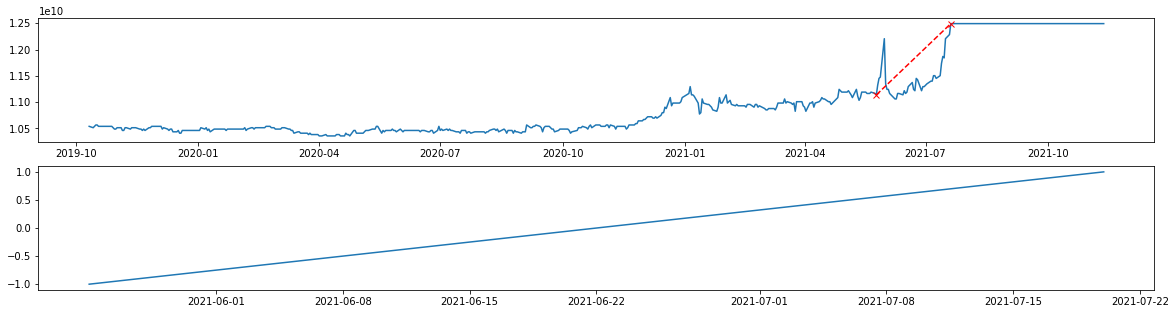

In [ ]:
#마지막 5번째 그림으로 확인


fig = plt.figure(figsize = (20, 5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


ax1.plot(samsung['TRD_DD'],samsung['MKTCAP'])
#ax1.set_xlim([datetime.date(2017, 7, 1), datetime.date(2021, 10, 20)])
#ax1.set_ylim(0,3e11)
#ax1.plot(x,y, color = "orange", linestyle = "--")

for i in range(result2.shape[0]):
  x1 = list(result2.iloc[i,:2])
  y1 = list(result2.iloc[i,2:4])
  ax1.plot(x1,y1, "rx--")


ax2.plot(samsung['TRD_DD'],samsung['TREND'])
#ax2.set_xlim([datetime.date(2019, 10, 1), datetime.date(2021, 10, 20)])

In [ ]:
(a == b).sum()

TRD_DD        502
ISU_CD        502
ISU_NM        502
TDD_CLSPRC    502
TDD_OPNPRC    502
TDD_HGPRC     502
TDD_LWPRC     502
MKTCAP        502
ACC_TRDVOL    502
EPS           502
PER           502
BPS           502
PBR           502
DPS           502
DVD_YLD       502
TREND         502
dtype: int64